In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.io import fits
from spectral_cube import SpectralCube
from spectral_cube import BooleanArrayMask
from astropy.convolution import Gaussian1DKernel, convolve
import aplpy  
from astropy.wcs import WCS
from reproject import reproject_interp
from astroquery.vizier import Vizier
from astroquery.skyview import SkyView
from astropy.time import Time

Vizier.ROW_LIMIT = -1

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '16'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [36]:
# maka a comparison plot showing the smoothed ATCA data and the ASKAP data

atca_file = 'j102809-2644'
coord = '10:28:09.68 -26:44:18.9'


def compare_ASKAP_ATCA(atca_file, coord):
    cube_askap = SpectralCube.read('/Users/denes/Research/high_lat_HI/ASKAP_data/Karens_test_v2/Hydra_MW.fits')  # Open the FITS file for reading
    cube_atca = SpectralCube.read('/Users/denes/Research/high_lat_HI/ATCA_data/hydra/{}_cube_4k.fits'.format(atca_file))  # Open the FITS file for reading
    cube_atca_2 = SpectralCube.read('/Users/denes/Research/high_lat_HI/ATCA_data/hydra/{}_cube_v2.fits'.format(atca_file))  # Open the FITS file for reading

    #cube_askap = SpectralCube.read('/Users/denes/Research/high_lat_HI/ASKAP_data/Karens_tests/image.restored.i.SB10269.cube.contsub.fits')  # Open the FITS file for reading

    askap = fits.open('/Users/denes/Research/high_lat_HI/ASKAP_data/Karens_test_v2/Hydra_MW.fits')  # Open the FITS file for reading
    d_askap = askap[0].data
    h_askap = askap[0].header
    w_askap = WCS(h_askap, askap)

    #print(h_askap)

    #coord = '10:28:09.68 -26:44:18.9'
    c = SkyCoord(coord, unit=(u.hourangle, u.deg))
    print(c.ra.hms, c.dec.dms)


    MRO = EarthLocation.of_site('mro') 
    #keck = EarthLocation.from_geodetic(lat=19.8283*u.deg, lon=-155.4783*u.deg, height=4160*u.m)
    barycorr = c.radial_velocity_correction(obstime=Time('2019-10-25'), location=MRO)  
    #barycorr = barycorr.to(u.km/u.s)

    atca = fits.open('/Users/denes/Research/high_lat_HI/ATCA_data/hydra/{}_cube_4k.fits'.format(atca_file))  # Open the FITS file for reading
    d_atca = atca[0].data
    h_atca = atca[0].header
    w_atca = WCS(h_atca, atca)

    restfreq = 1.420405752 * u.GHz  # rest frequency of HI
    freq_to_vel = u.doppler_optical(restfreq) # using the radio convention
    vel_askap = (cube_askap.spectral_axis).to(u.km / u.s, equivalencies=freq_to_vel) - barycorr/2

    pixels_askap = c.to_pixel(w_askap)
    pixels_atca = c.to_pixel(w_atca)

    print(pixels_askap)

    # ASKAP spectrum
    spectrum_askap = cube_askap[:, int(pixels_askap[1]), int(pixels_askap[0])]  
    tau_askap = np.log(spectrum_askap.value +1) * -1.
    rms_askap = np.sqrt(np.mean(spectrum_askap.value[0:100]**2))

    # ATCA spectrum
    spectrum_atca = cube_atca[:, int(pixels_atca[1]), int(pixels_atca[0])]  
    vel_atca = cube_atca.spectral_axis
    y1 = spectrum_atca[:300]
    x1 = vel_atca[-300:].value/1000
    y2 = spectrum_atca[:300]
    x2 = vel_atca[-300:].value/1000
    x = np.concatenate((x1,x2), axis=None)
    y = np.concatenate((y1,y2), axis=None)
    pars = np.polyfit(vel_atca.value, spectrum_atca.value, 1)
    p = np.poly1d(pars)

    g = Gaussian1DKernel(4.0)
    hismooth = convolve(spectrum_atca, g, boundary='extend')
    tauhi_smooth = hismooth/p(vel_atca.value/1000)
    tauhi = spectrum_atca/p(vel_atca.value/1000)
    tauhi = np.array(tauhi)
    tau_atca = np.log(tauhi) * -1.

    #tauhi = hismooth/p(hiv)
    minustauhi = 1. - tauhi
    minustauhi_smooth = 1. - tauhi_smooth
    rms_atca = np.sqrt(np.mean(tauhi**2))
    
    spectrum_atca_2 = cube_atca_2[:, int(pixels_atca[1]), int(pixels_atca[0])]  
    vel_atca_2 = cube_atca_2.spectral_axis
    y1 = spectrum_atca_2[:600]
    x1 = vel_atca_2[-600:].value/1000
    y2 = spectrum_atca_2[:600]
    x2 = vel_atca_2[-600:].value/1000
    x = np.concatenate((x1,x2), axis=None)
    y = np.concatenate((y1,y2), axis=None)
    pars_2 = np.polyfit(vel_atca_2.value, spectrum_atca_2.value, 1)
    p_2 = np.poly1d(pars_2)

    hismooth_2 = convolve(spectrum_atca_2, g, boundary='extend')
    tauhi_smooth_2 = hismooth_2/p(vel_atca_2.value/1000)
    tauhi_2 = spectrum_atca_2/p(vel_atca_2.value/1000)
    tauhi_2 = np.array(tauhi_2)
    
    print('rms askap, atca:', rms_askap, rms_atca)

    # plot
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111)
    plt.plot(vel_atca/1000, tauhi, 'C0', linewidth=3,  label='ATCA')
    #plt.plot(vel_atca_2/1000, tauhi_smooth_2, 'C0', linewidth=3, alpha=0.5,  label='ATCA')

    plt.plot(vel_askap, spectrum_askap.value+1, 'C1', linewidth=3, label='ASKAP')
    ax.axhspan(1-rms_askap, 1+rms_askap, alpha=0.5, color='lightgrey')
    plt.title('{}'.format(atca_file), fontsize=30)
    plt.ylabel(r'e$^{-\tau}$', fontsize=28)
    plt.xlabel("v [km/s]", fontsize=28)
    plt.xlim(-100,100)
    plt.axhline(1, color='k', linestyle='--')
    plt.legend(fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=25)
    fig.savefig('spectra_{}_ASKAP_ATCA_test.png'.format(atca_file))
    

hms_tuple(h=10.0, m=28.0, s=9.679999999999893) dms_tuple(d=-26.0, m=-44.0, s=-18.900000000004127)
(array(3953.50042373), array(2950.92986521))
rms askap, atca: 0.0018882019 1.0000391359847767


hms_tuple(h=10.0, m=19.0, s=8.520000000000607) dms_tuple(d=-27.0, m=-8.0, s=-56.50000000000233)
(array(5162.57401509), array(2723.71062099))


rms askap, atca: 0.0017967526 1.0028673638065853


hms_tuple(h=10.0, m=22.0, s=29.45000000000519) dms_tuple(d=-26.0, m=-47.0, s=-34.30000000000206)
(array(4712.87470113), array(2932.88536528))
rms askap, atca: 0.0017224484 1.0010505002638308


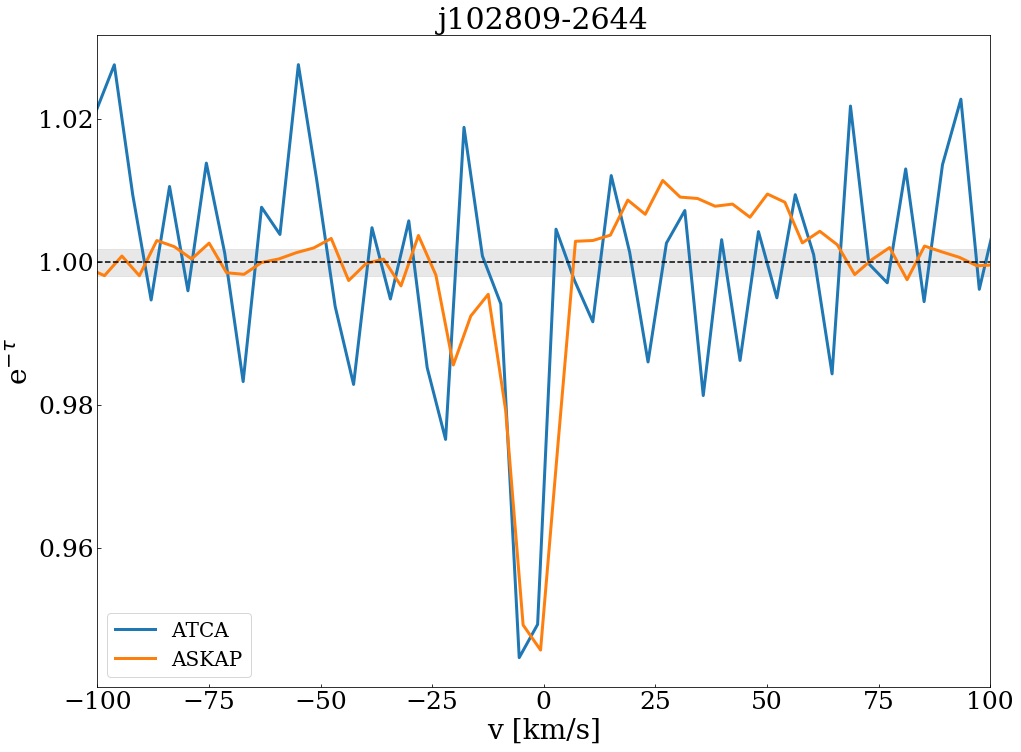

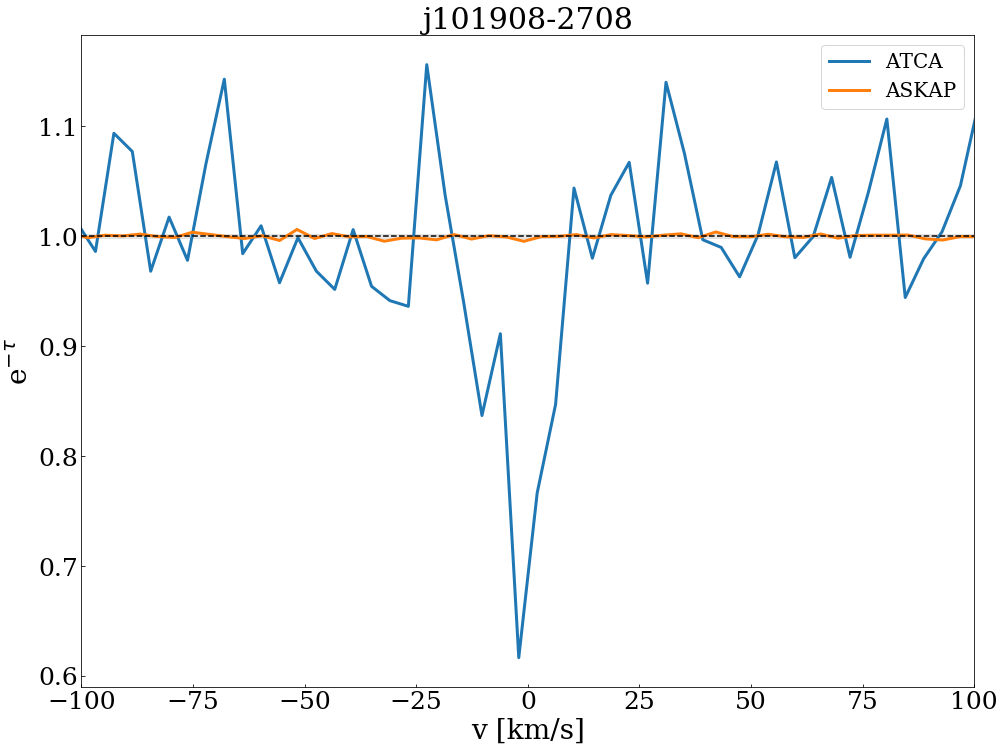

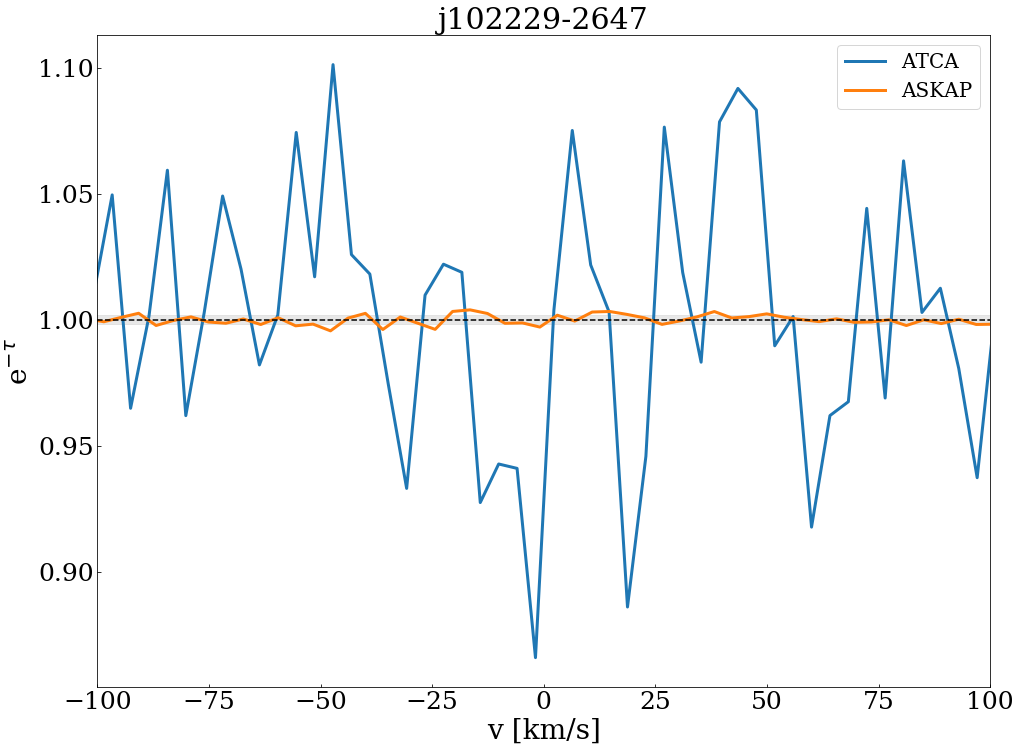

In [37]:

atca_files = ['j102809-2644', 'j101908-2708', 'j102229-2647']
coord = ['10:28:09.68 -26:44:18.9', '10:19:08.52 -27:08:56.5', '10:22:29.45 -26:47:34.3']

for i in range(len(atca_files)):
    compare_ASKAP_ATCA(atca_files[i], coord[i])